This project explores the landscape of machine learning through the use of the two most common
machine learning models: logistic and linear regression, which will be applied on two robust data
sets. The first regression problem is to predict the median housing cost of owner occupied homes
based on several features relating to the surrounding area. The second problem is a classification
problem, where we must determine the type of wine using its features.

In [717]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import matplotlib.cm as cm
import seaborn as sns

# Dataset Exploration

We start by reading in the data from their respective csvs. Please make sure to change the file paths or have the files for the datasets in the same directory.

We first make sure to get rid of any rows with missing values and to drop the "B" column as instructed in the Boston data set.

Since the wine column is not labelled, we assign labels to each column.

In [554]:
pd_wine = pd.read_csv('wines/wine.data')
pd_boston = pd.read_csv('boston.csv')
pd_boston = pd_boston.drop(["B"], axis=1)
pd_boston.dropna(inplace=True)
pd_wine.dropna(inplace=True)
pd_wine.columns = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols",
                   "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue",
                   "OD280/OD315 of diluted wines", "Proline"]


In [ ]:
pd_boston_raw = pd_boston

y_boston = pd_boston[["MEDV"]]
x_boston = pd_boston.drop("MEDV", axis=1)
x_boston = x_boston.to_numpy()
y_boston = y_boston.to_numpy()

In [556]:
y_wine = pd_wine[["Class"]]
x_wine = pd_wine.drop("Class", axis=1)
x_wine = x_wine.to_numpy()
y_wine = y_wine.to_numpy()

Our class for standardizing our features.

In [932]:
class normalizer:
    def __init__(self, x):
        self.mean_x = x.mean(axis=0)
        self.std_x = x.std(axis=0)

    def transform(self, x):
        x = ((x - self.mean_x) / self.std_x)
        return x
    def invert_x(self, x):
        return (x*self.std_x) + self.mean_x

Let's plot out the different data. A visual look at the different features and how they compare to the labels can be interesting and can give foresight into the data, this analysis should help us see some trends in the data.

In [957]:
pd_wine.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [958]:
pd_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2


<Axes: >

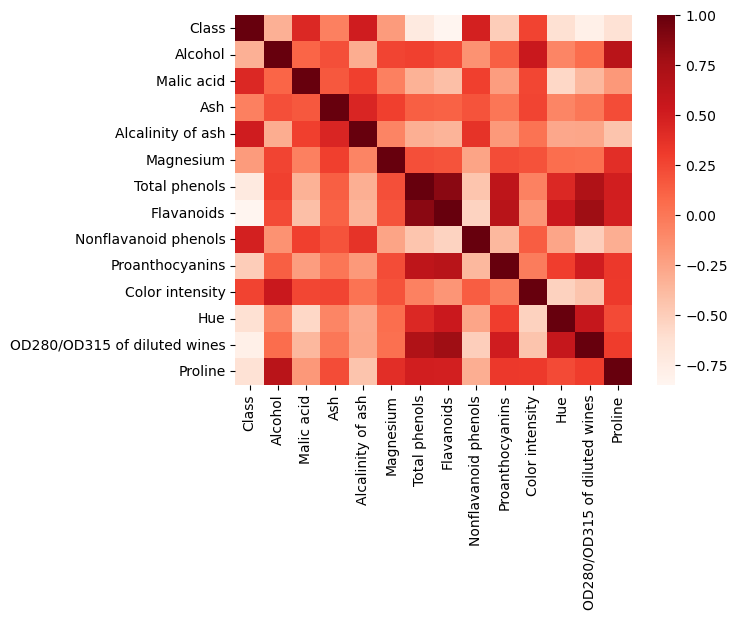

In [933]:
sns.heatmap(pd_wine.corr(), cmap="Reds")

In [934]:
pd_wine['Class'].value_counts()

2    71
1    58
3    48
Name: Class, dtype: int64

<Axes: xlabel='Class', ylabel='Flavanoids'>

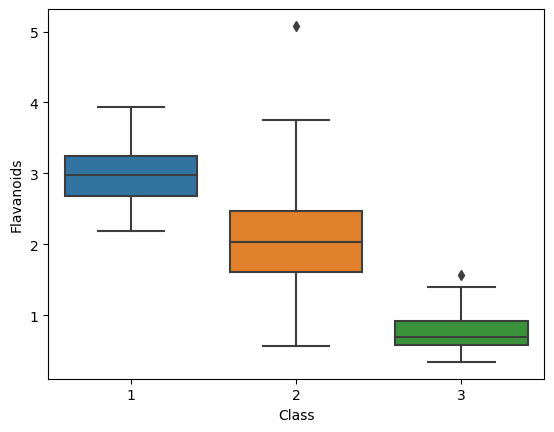

In [935]:
sns.boxplot(x = pd_wine['Class'], y= pd_wine['Flavanoids'])

<Axes: xlabel='Class', ylabel='Proline'>

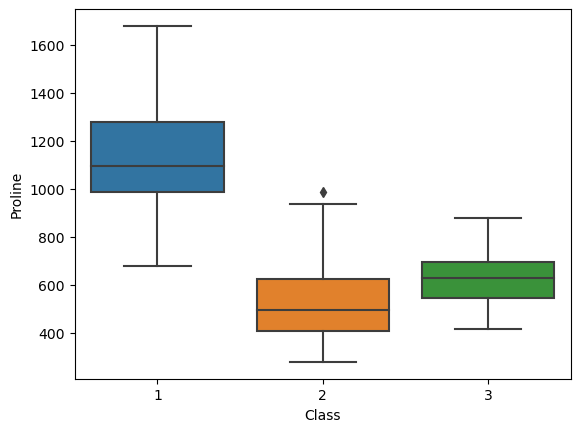

In [936]:
sns.boxplot(x = pd_wine['Class'], y= pd_wine['Proline'])

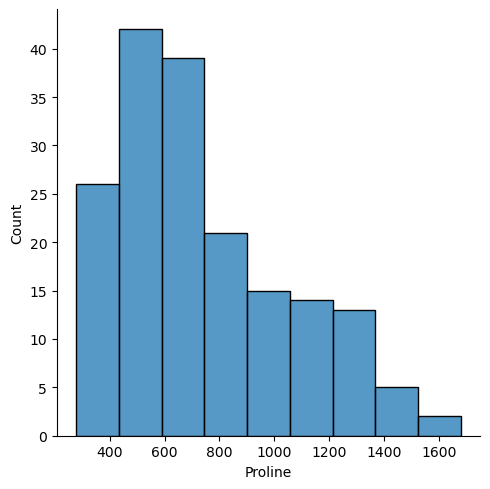

In [937]:
sns.displot(pd_wine['Proline'], legend=False)

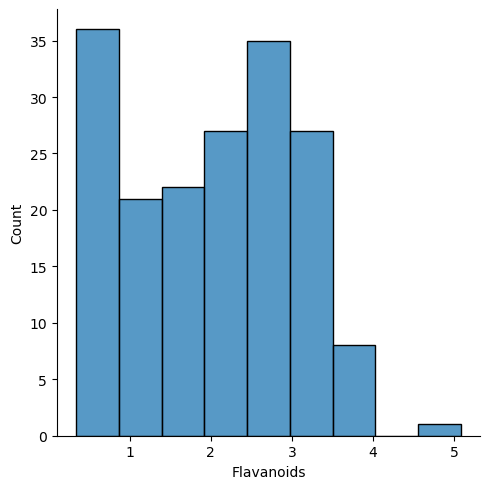

In [938]:
sns.displot(pd_wine['Flavanoids'], legend=False)


<Axes: >

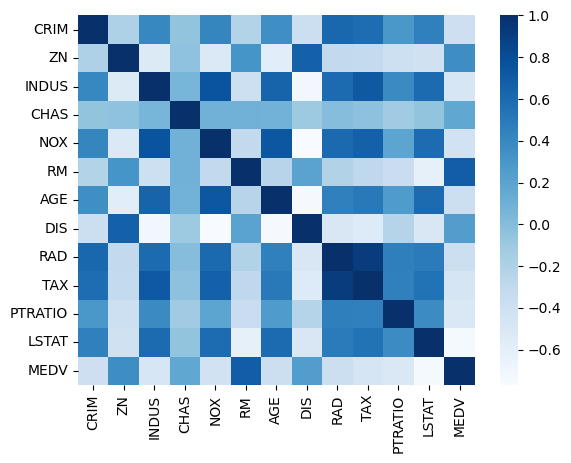

In [939]:
sns.heatmap(pd_boston.corr(), cmap='Blues')

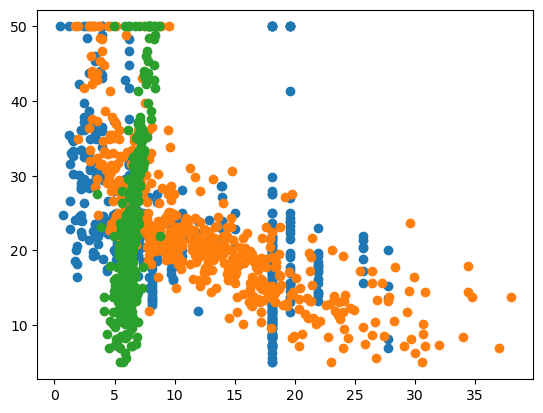

In [940]:
plt.scatter(pd_boston['INDUS'], y_boston)
plt.scatter(pd_boston['LSTAT'], y_boston)
plt.scatter(pd_boston['RM'], y_boston)

The labels and some features follow a gaussian with some outliers making standarization a good choice to make sure no exploding gradients occur.

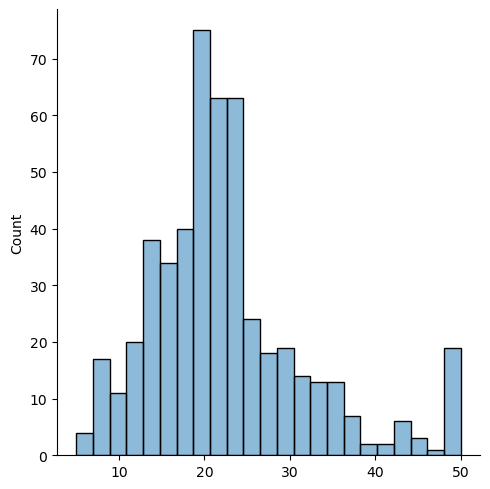

In [941]:
sns.displot(y_boston, legend=False)

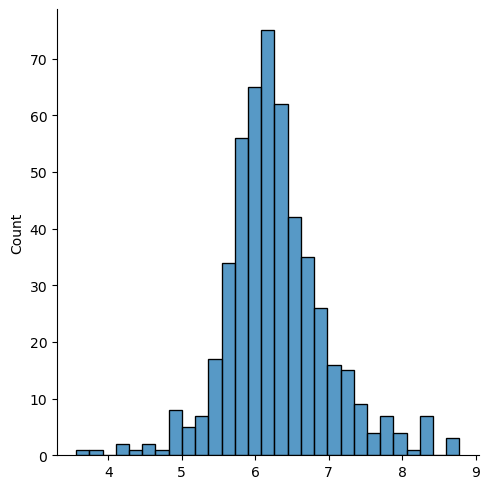

In [942]:
sns.displot(x_boston[:,5])


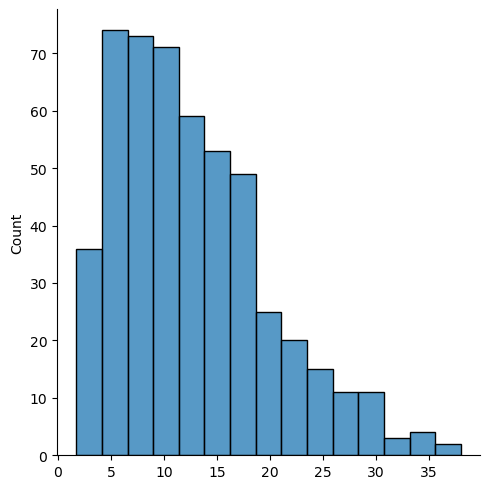

In [943]:
sns.displot(x_boston[:,11])

Since there are some normal dsitrbutions lets standardize the data.
## VERY IMPORTANT
When normalizing data we first want to split between train and test data. Normalize the train, and use the normalization paramters of the train set on the test set. We assume we have no knowledge of the test set. A very common mistake is to normalize based on all the data which is very wrong.

# Model Construction

First code block is the implementation of linear regression.
It has the following parameters: learning_rate, maximum iterations, epsilon (for when to stop), batchsize, boolean if we want to use mini_batch gradient descent, boolean for bias, a parameter called lambdaa with controls the regularization strength of ridge regression.

Logistic Regression has similar parameter names for the ones it does share (it also has momentum implemented.)

In [946]:
class LinearReg:
    def __init__(self, bias=False, mini_batch=False, learning_rate=0.1, epsilon=1e-4, max_iters=100, batchsize = 128, lambdaa=0.0, beta_momentum = 0, verbose=False):
        self.w = None
        self.bias = bias
        self.mini_batch = mini_batch
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.lambdaa = lambdaa
        self.costs = []
        self.iterations = []
        self.beta_momentum = beta_momentum
        self.verbose = verbose

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None] #Is the input an array? If so, turn it into a matrix, with each x as different sample.
        if not self.mini_batch: #Calculate the optimal w analytically.
            self.fit_analyitcal(x, y)
        else: #Calculate the optimal w using minibatch sgd.
            self.fit_minibatch(x,y)
        return self

    def fit_analyitcal(self, x, y):
        if self.bias:
            x = np.column_stack([np.ones(x.shape[0]),x ])
        I = numpy.identity(x.shape[1]) #Identity matrix.
        self.w = np.linalg.inv(x.T @ x + self.lambdaa * I) @ x.T @ y #Computre weights analytically
        return self

    def fit_minibatch(self,x ,y):
        if self.bias:
            x = np.column_stack([np.ones(x.shape[0]),x ])
        N,D = x.shape
        #Interesting to play around to have the weights be distributed around a normal or just all be 0.
        self.w = np.zeros(D)
        g = np.inf #g is our gradient variable
        t = 0
        running_average = 0 #The running average for momentum
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters: #Limit number of iterations by max iterations of dataset
            for batch in self.loop_minibatches(x,y, shuffle=True): #Get a piece of the dataset to use
                x_batch, y_batch = batch #Split tuple
                g = self.gradient(x_batch, y_batch) #Find gradient
                running_average = self.beta_momentum * running_average + (1 - self.beta_momentum) * g #Use momentum
                self.w = self.w - self.learning_rate * running_average #Update weights
                t += 1 #Increase time step

                if self.verbose:
                    self.iterations.append(t) #Append results for graphical uses.
                    self.costs.append(self.cost(y, y_hat= x @ self.w))
        return self

    def loop_minibatches(self, x, y, shuffle=True):
        if shuffle:
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
        for start_i in range(0, x.shape[0] - self.batchsize + 1, self.batchsize):
            if shuffle:
                piece = indices[start_i:start_i + self.batchsize]
            else:
                piece = slice(start_i, start_i + self.batchsize)
            yield x[piece], y[piece]

    def gradient(self, x, y):
        #Compute the gradient.
        N,D = x.shape
        self.w = self.w.reshape(D,1)
        yh = x @ self.w
        yh = yh.reshape(N,1)
        y  = y.reshape(N,1)
        grad = ( x.T @ (yh - y) ) / N
        return grad

    def cost(self,y,y_hat):
        return np.mean(np.square(np.subtract(y_hat, y)))

    def get_cost_with_iterations(self):
        return self.iterations, self.costs

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None] #If the input is just an array return a matrix.
        N = x.shape[0]
        if self.bias:
            x = np.column_stack([np.ones(N),x])
        y_hat = x @ self.w
        return y_hat #Calcualte the predicted y values.


In [948]:
class LogisticReg:
    def __init__(self, bias=False, mini_batch=False, batchsize = 128, learning_rate=0.1, epsilon=1e-4, max_iters=100, beta_momentum=0, verbose=False):
        self.w = None
        self.bias = bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.batchsize = batchsize
        self.mini_batch = mini_batch
        self.beta_momentum = beta_momentum
        self.costs = []
        self.iterations = []
        self.verbose = verbose

    def one_hot_encoding(self, y):
        #Turn each y into a one hot encoding
        y_encoded = []
        for i in y:
            if i == 1: y_encoded.append([1,0,0])
            elif i == 2: y_encoded.append([0,1,0])
            elif i == 3: y_encoded.append([0,0,1])
        return np.array(y_encoded)

    def fit(self, x , y):
        #Fit either with batch or mini batch
        if x.ndim == 1:
            x = x[:, None]
        if self.bias:
            N = x.shape[0]
            x = np.column_stack([np.ones(N),x])
        N,D = x.shape
        self.w = np.zeros([D, 3]) #num_classes = 3
        y_onehot = self.one_hot_encoding(y)

        if self.mini_batch:
            self.fit_minibatch(x,y_onehot)
        else:
            self.fit_grad(x,y_onehot)
        return self

    def fit_grad(self, x, y):
        g = np.inf
        running_average = 0
        t=0
        #Gradient descent with momentum
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            running_average = self.beta_momentum * running_average + (1 - self.beta_momentum) * g
            self.w = self.w - self.learning_rate * running_average
            t += 1
            if self.verbose:
                self.iterations.append(t)
                self.costs.append(self.cost(n=x.shape[0], y=y, y_hat=self.softmax(x @ self.w)))

    def fit_minibatch(self, x, y):
        g = np.inf
        t = 0
        running_average = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            for batch in self.loop_minibatches(x,y):
                x_batch, y_batch = batch
                g = self.gradient(x_batch, y_batch)
                running_average = self.beta_momentum * running_average + (1 - self.beta_momentum) * g
                self.w = self.w - self.learning_rate * running_average
                t += 1
                if self.verbose:
                    self.iterations.append(t)
                    self.costs.append(self.cost(n=x_batch.shape[0], y=y, y_hat=self.softmax(x @ self.w)))
        return self

    def loop_minibatches(self, x, y, shuffle=True):
        if shuffle:
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
        for start_i in range(0, x.shape[0] - self.batchsize + 1, self.batchsize):
            if shuffle:
                piece = indices[start_i:start_i + self.batchsize]
            else:
                piece = slice(start_i, start_i + self.batchsize)
            yield x[piece], y[piece]

    def softmax(self, z):
        sumz = (np.sum(np.exp(z), axis = 1 )).reshape(-1, 1)
        soft = ((np.exp(z)) / sumz)
        return soft

    def gradient(self, x, y):
        N,D = x.shape
        yh = self.softmax(x @ self.w)
        grad = (x.T @ (yh - y) ) /N        # divide by N because cost is mean over N points
        return grad

    def cost(self,n,y,y_hat):
        result = -(np.sum(y * np.log(y_hat)))/n
        return result

    def get_cost_with_iterations(self):
        return self.iterations, self.costs

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.bias:
            x = np.column_stack([np.ones(Nt),x])
        yh = self.softmax(x @ self.w)            #predict output
        #return yh
        return np.argmax(yh, axis=1)+1

# Experiments

### 1.

In [949]:
#This shuffles indices that we use for training and testing. There are parameters for the size of the training data and for a random seed for replicable results.
def train_test_split(x, y, train_size=0.8, seed=None):
    size = x.shape[0]
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.permutation(size)
    split = int(size * train_size)
    training_idx, test_idx = indices[:split], indices[split:]
    x_train, x_test, y_train, y_test = x[training_idx,:], x[test_idx,:], y[training_idx, :], y[test_idx, :]
    return x_train, x_test, y_train, y_test

#Lambda function for MSE
MSE = lambda yhat, y_test : np.mean(np.square(np.subtract(yhat, y_test)))

#A logistic metric function which return all metrics at once. Specifically uses micro versions of the metrics.
def metrics_classifier(yhat, ytest):
    yhat = yhat.flatten()
    ytest = ytest.flatten()
    num_classes = set(ytest)
    accuracy = np.mean(yhat == ytest)
    precision_arr = []
    recall_arr = []
    for i in num_classes:
        TP = ((yhat==i) & (ytest==i)).sum()
        FP = ((yhat==i) & (ytest!=i)).sum()
        P = (ytest == i).sum()
        precision_arr.append(TP/ (TP+FP))
        recall_arr.append(TP / P)
    precision_arr= np.array(precision_arr)
    recall_arr = np.array(recall_arr)
    precision = precision_arr.mean()
    recall = recall_arr.mean()
    f1 = precision * recall * 2 / (precision + recall)
    return accuracy, precision, recall, f1

In [954]:
#Run our first test!
#Run linear regression analytically
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
model = LinearReg(bias=True, mini_batch=False)
model.fit(X_train_boston, Y_train_boston)
print("Linear Regression:")
print(f"MSE of linear regression on TRAIN data is {MSE(model.predict(X_train_boston), Y_train_boston)}")
print(f"MSE of linear regression on TEST data is {MSE(model.predict(X_test_boston), Y_test_boston)}")

#Run SGD wtih logistic
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=0.8, seed=1)
n = normalizer(X_train_wine)
X_train_wine = n.transform(X_train_wine)
X_test_wine = n.transform(X_test_wine)
model = LogisticReg(mini_batch=False, max_iters=1000, learning_rate=0.001)
model.fit(X_train_wine, Y_train_wine)
yhat_train_wine = model.predict(X_train_wine)
yhat_test_wine = model.predict(X_test_wine)

acc_train ,precision_train , recall_train,f1_train = metrics_classifier(yhat_train_wine, Y_train_wine)
acc_test ,precision_test,recall_test,f1_test = metrics_classifier(yhat_test_wine, Y_test_wine)
print("Logistic Regression:")
print(f"TRAIN DATA: Accuracy : {acc_train} Precision : {precision_train} Recall : {recall_train} f1 : {f1_train}")
print(f"TEST DATA: Accuracy : {acc_test} Precision : {precision_test} Recall : {recall_test} f1 : {f1_test}")

Linear Regression:
MSE of linear regression on TRAIN data is 22.283503359521855
MSE of linear regression on TEST data is 23.341013525985918
Logistic Regression:
TRAIN DATA: Accuracy : 0.9645390070921985 Precision : 0.9582456140350878 Recall : 0.9712643678160919 f1 : 0.9647110709791774
TEST DATA: Accuracy : 0.9444444444444444 Precision : 0.9444444444444443 Recall : 0.9487179487179488 f1 : 0.946576373212942


### 2. Splitting the folds!

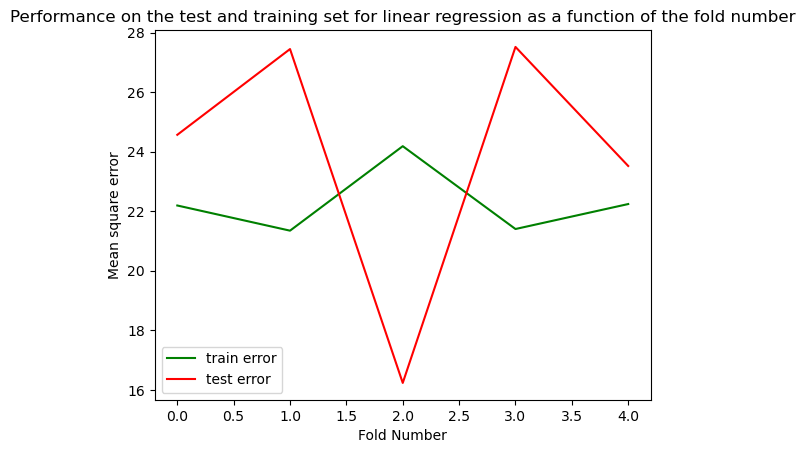

Average MSE for train y is 22.2743823200193
Average MSE for test y is 23.858225996421424


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1) #We are using 5 folds. Make sure to shuffle data.
kf.get_n_splits(x_boston) #Get splits
#Store MSE of each fold test.
MSE_train_over_folds = []
MSE_test_over_folds = []
folds = []
for i, (train_index, test_index) in enumerate(kf.split(x_boston)):
    #Get train data based on index
    train_fold = x_boston[train_index, :]
    train_fold_y = y_boston[train_index, :]
    #Get test data based on index
    test_fold = x_boston[test_index, :]
    test_fold_y = y_boston[test_index, :]
    #Normalize
    n = normalizer(train_fold)
    train_fold = n.transform(train_fold)
    test_fold= n.transform(test_fold)
    #Fit and get metrics
    reg = LinearReg(mini_batch=False, bias=True)
    reg.fit(train_fold, train_fold_y)
    #We will be storing metrics for both test and train.
    yhat_train_fold = (reg.predict(train_fold))
    yhat_test_fold =  (reg.predict(test_fold))
    MSE_train_over_folds.append(MSE(yhat_train_fold, (train_fold_y)))
    MSE_test_over_folds.append(MSE(yhat_test_fold, test_fold_y))
    folds.append(i)

plt.plot(folds, MSE_train_over_folds, color='g', label='train error')
plt.xlabel('Fold Number')
plt.ylabel('Mean square error')
plt.title('Performance on the test and training set for linear regression as a function of the fold number')
plt.plot(folds, MSE_test_over_folds, color='r', label='test error')
plt.legend()
plt.show()
print(f"Average MSE for train y is {np.mean(np.array(MSE_train_over_folds))}")
print(f"Average MSE for test y is {np.mean(np.array(MSE_test_over_folds))}")

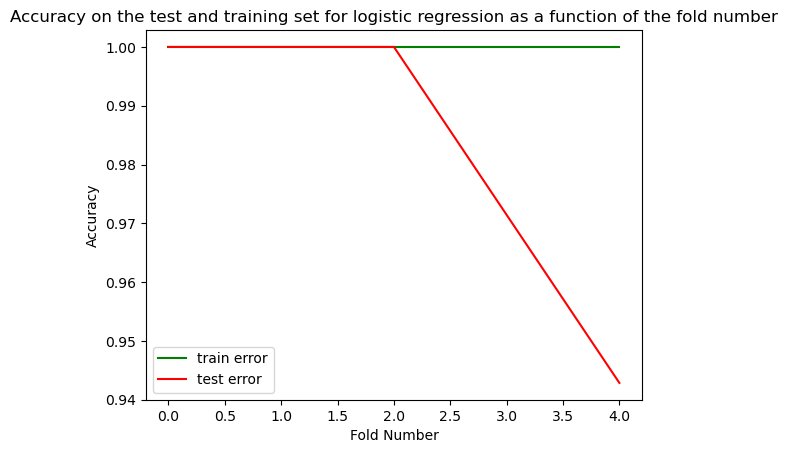

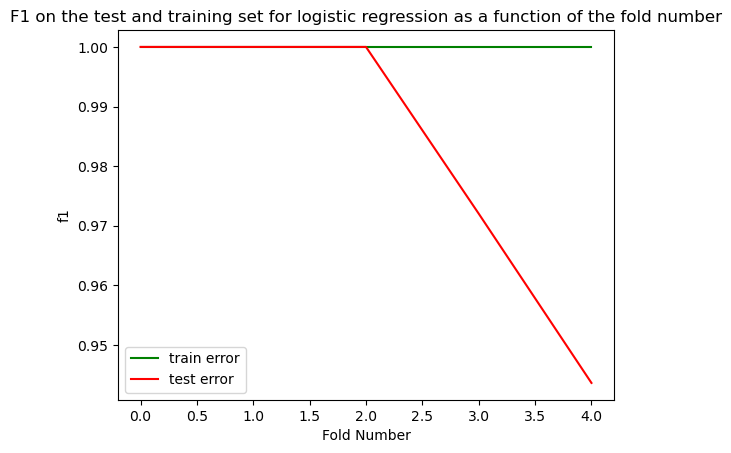

Average accuracy for train y is 1.0
Average accuracy for test y is 0.9828571428571429
Average f1 for train y is 1.0
Average f1 for test y is 0.983129829189634


In [809]:
from sklearn.model_selection import KFold
#Same procedure but for logistic
kf = KFold(n_splits=5, shuffle=True, random_state=1)
kf.get_n_splits(x_wine)
f1_train_over_folds = []
accuracy_train_over_folds = []
f1_test_over_folds = []
accuracy_test_over_folds = []
folds = []
for i, (train_index, test_index) in enumerate(kf.split(x_wine)):
    train_fold = x_wine[train_index, :]
    train_fold_y = y_wine[train_index, :]
    test_fold = x_wine[test_index, :]
    test_fold_y = y_wine[test_index, :]

    n = normalizer(train_fold)
    train_fold = n.transform(train_fold)
    test_fold = n.transform(test_fold)

    reg = LogisticReg(mini_batch=False, bias=True, max_iters=500, learning_rate=0.1)
    reg.fit(train_fold, train_fold_y)

    yhat_train_fold = reg.predict(train_fold)
    yhat_test_fold = reg.predict(test_fold)
    #Will report just accuracy and f1 as f1 is just a combination of recall and precision, and we don't care for a specific one.
    acc_train ,_,_,f1_train = metrics_classifier(yhat_train_fold, train_fold_y)
    acc_test ,_,_,f1_test = metrics_classifier(yhat_test_fold, test_fold_y)
    f1_train_over_folds.append(f1_train)
    accuracy_train_over_folds.append(acc_train)
    f1_test_over_folds.append(f1_test)
    accuracy_test_over_folds.append(acc_test)
    folds.append(i)

plt.plot(folds, accuracy_train_over_folds, color='g', label='train error')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Accuracy on the test and training set for logistic regression as a function of the fold number')
plt.plot(folds, accuracy_test_over_folds, color='r', label='test error')
plt.legend()
plt.show()

plt.plot(folds, f1_train_over_folds, color='g', label='train error')
plt.xlabel('Fold Number')
plt.ylabel('f1')
plt.title('F1 on the test and training set for logistic regression as a function of the fold number')
plt.plot(folds, f1_test_over_folds, color='r', label='test error')
plt.legend()
plt.show()


print(f"Average accuracy for train y is {np.mean(np.array(accuracy_train_over_folds))}")
print(f"Average accuracy for test y is {np.mean(np.array(accuracy_test_over_folds))}")
print(f"Average f1 for train y is {np.mean(np.array(f1_train_over_folds))}")
print(f"Average f1 for test y is {np.mean(np.array(f1_test_over_folds))}")

### 3.

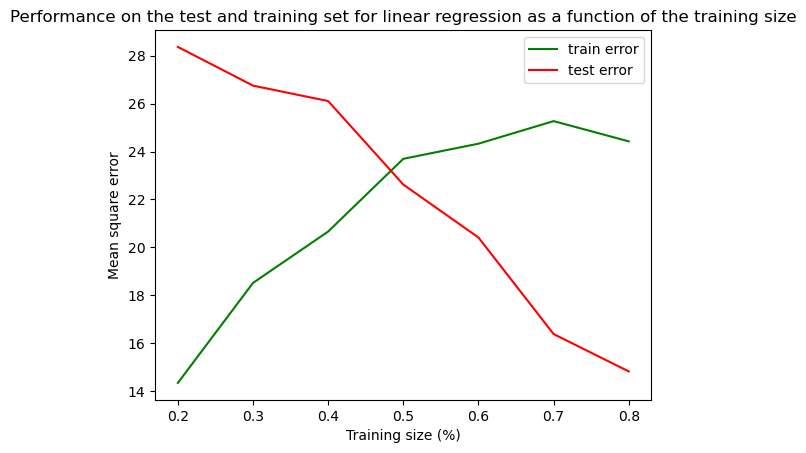

In [852]:
growing_train_sizes = np.arange(start=0.2, stop=0.8, step=0.1)
MSE_array_train = []
MSE_array_test = []
#Linear Regression

for i in growing_train_sizes:
    X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=i, seed=2)
    n = normalizer(X_train_boston)
    X_train_boston = n.transform(X_train_boston)
    X_test_boston = n.transform(X_test_boston)
    reg = LinearReg(mini_batch=False, bias=True)
    reg.fit(X_train_boston, Y_train_boston)
    yhat_train_boston = (reg.predict(X_train_boston))
    yhat_test_boston = (reg.predict(X_test_boston))
    MSE_array_train.append(MSE(yhat_train_boston, (Y_train_boston)))
    MSE_array_test.append(MSE(yhat_test_boston, Y_test_boston))

plt.plot(growing_train_sizes, MSE_array_train, color='g', label='train error')
plt.xlabel('Training size (%)')
plt.ylabel('Mean square error')
plt.title('Performance on the test and training set for linear regression as a function of the training size')
plt.plot(growing_train_sizes, MSE_array_test, color='r', label='test error')
plt.legend()
plt.show()

We see that for 0.2 training size, the train error is the lowest, but the test error is quite high. As the size of the test training increases, the test error goes down and the train error goes up.

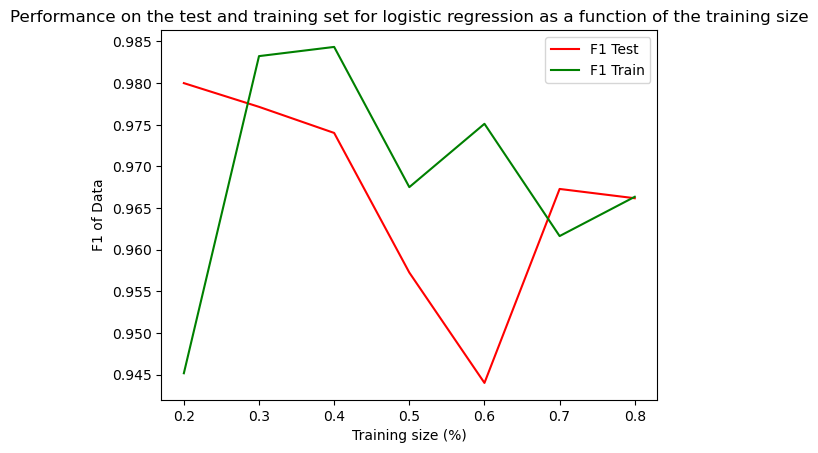

In [308]:
#Logistic Regression
growing_train_sizes = np.arange(start=0.2, stop=0.8, step=0.1)
f1_array_train = []
f1_array_test = []
#Logistic
for i in growing_train_sizes:
    X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=i)
    reg = LogisticReg(mini_batch=False, bias=True, max_iters=100, learning_rate=0.01)
    n = normalizer(X_train_wine)
    X_train_wine = n.transform(X_train_wine)
    X_test_wine = n.transform(X_test_wine)
    reg.fit(X_train_wine, Y_train_wine)
    yhat_train_wine = reg.predict(X_train_wine)
    yhat_test_wine = reg.predict(X_test_wine)

    acc_train ,_,_,f1_train = metrics_classifier(yhat_train_wine, Y_train_wine)
    acc_test ,_,_,f1_test = metrics_classifier(yhat_test_wine, Y_test_wine)
    f1_array_train.append(f1_train)
    f1_array_test.append(f1_test)

plt.plot(growing_train_sizes, f1_array_test, color = 'r', label="F1 Test")
plt.plot(growing_train_sizes, f1_array_train, color= 'g', label="F1 Train")
plt.xlabel('Training size (%)')
plt.ylabel('F1 of Data')
plt.legend()
plt.title('Performance on the test and training set for logistic regression as a function of the training size')

plt.show()

### 4.

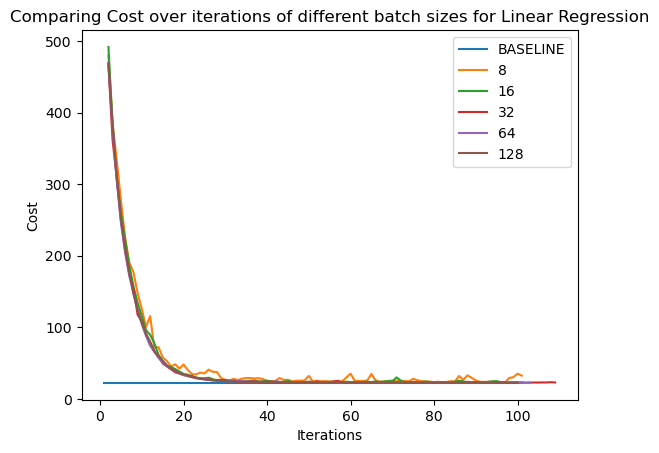

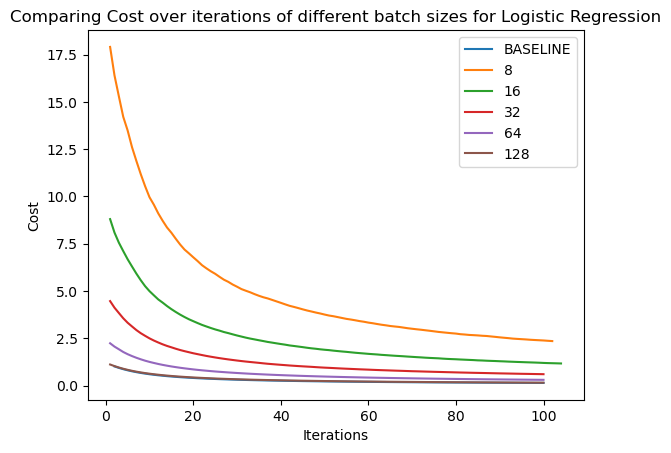

In [845]:
growing_batch_sizes = 2 ** np.arange(3,8,1)
####Linear Regression
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
#BASELINE
baseline = LinearReg(mini_batch=False, bias=True)
baseline.fit(X_train_boston, Y_train_boston)


plt.plot(np.arange(1,101), [MSE(baseline.predict(X_train_boston), Y_train_boston)] * 100, label="BASELINE")
#DIFFERENT BATCH SIZES
for i in growing_batch_sizes:
    reg = LinearReg(mini_batch=True, bias=True, max_iters=100, batchsize=i, learning_rate=0.1, verbose=True)
    reg.fit(X_train_boston, Y_train_boston)
    iters, costers = reg.get_cost_with_iterations()
    plt.plot(iters, costers, label=f"{i}")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Comparing Cost over iterations of different batch sizes for Linear Regression")
plt.show()

###########################

###Logistic Regression
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=0.8, seed=1)
n = normalizer(X_train_wine)
X_train_wine = n.transform(X_train_wine)
X_test_wine = n.transform(X_test_wine)
#BASELINE
logreg = LogisticReg(mini_batch=False, bias=True, learning_rate=0.05, max_iters=100, verbose=True)
logreg.fit(X_train_wine, Y_train_wine)
iters, costers = logreg.get_cost_with_iterations()
plt.plot(iters, costers, label="BASELINE")
#DIFFERENT BATCH SIZES
for i in growing_batch_sizes:
    logreg = LogisticReg(mini_batch=True, bias=True, learning_rate=0.05, max_iters=100, batchsize=i, verbose=True)
    logreg.fit(X_train_wine, Y_train_wine)
    iters, costers = logreg.get_cost_with_iterations()
    plt.plot(iters, costers, label=f"{i}")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Comparing Cost over iterations of different batch sizes for Logistic Regression")
plt.show()

### 5.

In [847]:
learing_rates = [0.00001, 0.001, 0.1]
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
for i in learing_rates:
    linreg = LinearReg(mini_batch=True, bias=True, learning_rate=i, batchsize=128, max_iters=500)
    linreg.fit(X_train_boston, Y_train_boston)
    print(f"The MSE Score for learing rate {i} is {MSE((linreg.predict(X_test_boston)), Y_test_boston)}")

print("####################################################")
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=0.8, seed=3)
norm = normalizer(X_train_wine)
X_train_wine = norm.transform(X_train_wine)
X_test_wine = norm.transform(X_test_wine)

for i in learing_rates:
    logreg = LogisticReg(mini_batch=True, bias=True, learning_rate=i, max_iters=500, batchsize=128)
    logreg.fit(X_train_wine, Y_train_wine)
    acc_test ,_,_,f1_test = metrics_classifier(logreg.predict(X_test_wine), Y_test_wine)
    print(f"The accuracy for learning rate {i} is {acc_test}")
    print(f"The f1 for learning rate {i} is {f1_test}")

The MSE Score for learing rate 1e-05 is 568.8095293836277
The MSE Score for learing rate 0.001 is 221.79158883398426
The MSE Score for learing rate 0.1 is 23.491789777350334
####################################################
The accuracy for learning rate 1e-05 is 0.8888888888888888
The f1 for learning rate 1e-05 is 0.9021633839199226
The accuracy for learning rate 0.001 is 0.9166666666666666
The f1 for learning rate 0.001 is 0.9263103269330566
The accuracy for learning rate 0.1 is 1.0
The f1 for learning rate 0.1 is 1.0


### 6.

In [899]:
# Since batch sizes are also parameters, we are going to test the 4 methods, so analytical linear, minibatch linear, gradient logistic and minibatch logistic

## Linear Regression
batch_sizes = [8, 32, 64]
bias = [True, False]
beta = [0.1, 0.9, 0.95]
learning_rates = [0.01, 0.1]
max_iters = [100, 500, 1000]

X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=3)
n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
#Minibatch linear regression
df = pd.DataFrame(columns=['MSE', 'Batch_Sizes', 'Max_Iterations', 'Beta', 'lr', 'Bias'])
combinations = np.array(np.meshgrid(batch_sizes, bias, beta, learning_rates, max_iters)).T.reshape(-1,5)
for i in combinations: #beta, learning_rates, batch_sizes
    bs_i, bias_i, beta_i, lr_i, mi_i = i
    reg = LinearReg(mini_batch=True, bias=bias_i, beta_momentum=beta_i, batchsize=int(bs_i), learning_rate=lr_i, max_iters=mi_i)
    reg.fit(X_train_boston, Y_train_boston)
    yhat = reg.predict(X_test_boston)
    score = MSE((yhat), Y_test_boston)
    df.loc[len(df)] = [score, bs_i, mi_i, beta_i, lr_i, bias_i]
print(df.to_string())

            MSE  Batch_Sizes  Max_Iterations  Beta    lr  Bias
0     86.097150          8.0           100.0  0.10  0.01   1.0
1    542.550351          8.0           100.0  0.10  0.01   0.0
2     77.614094         32.0           100.0  0.10  0.01   1.0
3    529.420686         32.0           100.0  0.10  0.01   0.0
4     85.464616         64.0           100.0  0.10  0.01   1.0
5    533.128920         64.0           100.0  0.10  0.01   0.0
6     90.286654          8.0           100.0  0.90  0.01   1.0
7    538.264381          8.0           100.0  0.90  0.01   0.0
8     77.922333         32.0           100.0  0.90  0.01   1.0
9    535.031157         32.0           100.0  0.90  0.01   0.0
10    85.816632         64.0           100.0  0.90  0.01   1.0
11   531.734315         64.0           100.0  0.90  0.01   0.0
12    94.002411          8.0           100.0  0.95  0.01   1.0
13   535.952277          8.0           100.0  0.95  0.01   0.0
14    81.415854         32.0           100.0  0.95  0.0

In [900]:
## Logistic regression
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=0.8, seed=1)
norm = normalizer(X_train_wine)
X_train_wine = norm.transform(X_train_wine)
X_test_wine = norm.transform(X_test_wine)

batch_sizes = [8, 32, 64]
bias = [True, False]
beta = [0.1, 0.9, 0.95]
learning_rates = [0.01, 0.1]
max_iters = [100, 500, 1000]

combinations = np.array(np.meshgrid(batch_sizes, bias, beta, learning_rates, max_iters)).T.reshape(-1,5)
df = pd.DataFrame(columns=['Accuracy', 'F1', 'Batch_Sizes', 'Max_Iterations', 'Beta', 'lr', 'Bias'])
for i in combinations: #beta, learning_rates, batch_sizes
    bs_i, bias_i, beta_i, lr_i, mi_i = i
    reg = LogisticReg(mini_batch=True, beta_momentum=beta_i, batchsize=int(bs_i), learning_rate=lr_i, max_iters=int(mi_i), bias=bias_i)
    reg.fit(X_train_wine, Y_train_wine)
    yhat = reg.predict(X_test_wine)
    acc_test ,_,_,f1_test = metrics_classifier(yhat, Y_test_wine)
    df.loc[len(df)] = [acc_test, f1_test, bs_i, mi_i, beta_i, lr_i, bias_i]
print(df.to_string())

     Accuracy        F1  Batch_Sizes  Max_Iterations  Beta    lr  Bias
0    0.944444  0.946576          8.0           100.0  0.10  0.01   1.0
1    0.944444  0.946576          8.0           100.0  0.10  0.01   0.0
2    0.944444  0.946576         32.0           100.0  0.10  0.01   1.0
3    0.944444  0.946576         32.0           100.0  0.10  0.01   0.0
4    0.944444  0.946576         64.0           100.0  0.10  0.01   1.0
5    0.944444  0.946576         64.0           100.0  0.10  0.01   0.0
6    0.944444  0.946576          8.0           100.0  0.90  0.01   1.0
7    0.944444  0.946576          8.0           100.0  0.90  0.01   0.0
8    0.944444  0.946576         32.0           100.0  0.90  0.01   1.0
9    0.944444  0.946576         32.0           100.0  0.90  0.01   0.0
10   0.944444  0.946576         64.0           100.0  0.90  0.01   1.0
11   0.944444  0.946576         64.0           100.0  0.90  0.01   0.0
12   0.944444  0.946576          8.0           100.0  0.95  0.01   1.0
13   0

Most models end up coverging, will talk about this in report.

### 7.

GAUSSIAN BASIS WITH OUR STANDARDIZATION

In [920]:
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
n = normalizer(X_train_boston)
X_train_boston= n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)

spatial_scale = 1
indices = np.random.choice(X_train_boston.shape[0], 5)
mu_i = np.array([ X_train_boston[i, :] for i in indices])
gaussian = lambda x, mu, sigma: np.exp(  -(np.linalg.norm((x-mu), axis=1))**2 /(2*sigma) )
####
new_features_train = []
new_features_test = []
for i in mu_i:
    new_features_train.append(( gaussian(X_train_boston, i, spatial_scale).reshape(-1,1)))
    new_features_test.append(( gaussian(X_test_boston, i, spatial_scale).reshape(-1,1)))

X_train_boston = np.concatenate(new_features_train, axis=1)
X_test_boston = np.concatenate(new_features_test, axis=1)
#print(X_train_boston.shape)
linregression = LinearReg(mini_batch=False, bias=True)
linregression.fit(X_train_boston, Y_train_boston)
yhat_train = linregression.predict(X_train_boston)
yhat_test = linregression.predict(X_test_boston)
print(f"The MSE for training data is {MSE(yhat_train, Y_train_boston)}")
print(f"The MSE for test data is {MSE(yhat_test, Y_test_boston)}")

The MSE for training data is 72.0454163355944
The MSE for test data is 78.10790323561116


What if we did it without standardization?

In [931]:
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)

spatial_scale = 1
indices = np.random.choice(X_train_boston.shape[0], 5)

mu_i = np.array([ X_train_boston[i, :] for i in indices])
gaussian = lambda x, mu, sigma: np.exp(  -(np.linalg.norm((x-mu), axis=1))**2 /(2*sigma) )
####
new_features_train = []
new_features_test = []
for i in mu_i:
    new_features_train.append(( gaussian(X_train_boston, i, spatial_scale).reshape(-1,1)))
    new_features_test.append(( gaussian(X_test_boston, i, spatial_scale).reshape(-1,1)))

X_train_boston = np.concatenate(new_features_train, axis=1)
X_test_boston = np.concatenate(new_features_test, axis=1)
linregression = LinearReg(mini_batch=False, bias=True)
linregression.fit(X_train_boston, Y_train_boston)
yhat_train = linregression.predict(X_train_boston)
yhat_test = linregression.predict(X_test_boston)
print(f"The MSE for training data is {MSE(yhat_train, Y_train_boston)}")
print(f"The MSE for test data is {MSE(yhat_test, Y_test_boston)}")

The MSE for training data is 82.85804718973188
The MSE for test data is 87.87233768849619


### 8.

In [927]:
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
reg = LinearReg(mini_batch=False, bias=True)
reg2 = LinearReg(mini_batch=True, bias=True, max_iters=1000, batchsize=64, beta_momentum=0.95)
reg.fit(X_train_boston, Y_train_boston)
reg2.fit(X_train_boston, Y_train_boston)
yhat_train_boston = reg.predict(X_train_boston)
yhat_test_boston = reg.predict(X_test_boston)
yhat2_train_boston = reg2.predict(X_train_boston)
yhat2_test_boston = reg2.predict(X_test_boston)

print(f"TRAINING SET: MSE of ANALYTICAL Linear Regression: {MSE(yhat_train_boston, Y_train_boston)}. MSE of MINIBATCH Linear Regression: {MSE(yhat2_train_boston, Y_train_boston)}")
print(f"    TEST SET: MSE of ANALYTICAL Linear Regression: {MSE(yhat_test_boston, Y_test_boston)}. MSE of MINIBATCH Linear Regression: {MSE(yhat2_test_boston, Y_test_boston)}")

TRAINING SET: MSE of ANALYTICAL Linear Regression: 22.283503359521852. MSE of MINIBATCH Linear Regression: 22.293507436083047
    TEST SET: MSE of ANALYTICAL Linear Regression: 23.34101352598724. MSE of MINIBATCH Linear Regression: 23.29693366624948


# Miscellaneous Experiments

What happens when we add more basis functions?? What happens if we increase spatial scale?

In [875]:
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=2)

n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston= n.transform(X_test_boston)

spatial_scales = [1,10,100]
for spatial_scale in spatial_scales:
    indices = np.random.choice(X_train_boston.shape[0], 5)
    mu_i = np.array([ X_train_boston[i, :] for i in indices])
    gaussian = lambda x, mu, sigma: np.exp(-(  np.linalg.norm((x-mu), axis=1) /sigma)**2)
    new_features_train = []
    new_features_test = []
    for i in mu_i:
        new_features_train.append(( gaussian(X_train_boston, i, spatial_scale).reshape(-1,1)))
        new_features_test.append(( gaussian(X_test_boston, i, spatial_scale).reshape(-1,1)))
    X_train_boston = np.concatenate(new_features_train, axis=1)
    X_test_boston = np.concatenate(new_features_test, axis=1)
    #print(X_train_boston.shape)
    linregression = LinearReg(mini_batch=False, lambdaa=0.001, bias=True)
    linregression.fit(X_train_boston, Y_train_boston)
    print(f"The MSE Score for {spatial_scale} scale value is {MSE((linregression.predict(X_train_boston)),(Y_train_boston))}")
    print(f"The MSE Score for {spatial_scale} scale value is {MSE((linregression.predict(X_test_boston)), Y_test_boston)}")

The MSE Score for 1 scale value is 85.23021070211801
The MSE Score for 1 scale value is 59.09142661801912
The MSE Score for 10 scale value is 94.91860866912592
The MSE Score for 10 scale value is 58.94689698193889
The MSE Score for 100 scale value is 688.4206067787251
The MSE Score for 100 scale value is 729.7811641197006


Different feature manipulation methods

In [877]:
#No normalization
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=3)

linregression = LinearReg(mini_batch=False, bias=True)
linregression.fit(X_train_boston, Y_train_boston)
print(f"The MSE Train Score without normalization is: {MSE(linregression.predict(X_train_boston), Y_train_boston)}")
print(f"The MSE Test Score without normalization is: {MSE(linregression.predict(X_test_boston), Y_test_boston)}")

#Min max normalization
x_min = X_train_boston.min(axis=0)
x_max = X_train_boston.max(axis=0)
x_train_scaled = (X_train_boston - x_min) / (x_max - x_min)
x_test_scaled = (X_test_boston - x_min) / (x_max - x_min)

linregression = LinearReg(mini_batch=False, bias=True)
linregression.fit(x_train_scaled, Y_train_boston)
print(f"The MSE Score for min max normaliaztion {MSE(linregression.predict(x_train_scaled), Y_train_boston)}")
print(f"The MSE Score for min max normaliaztion {MSE(linregression.predict(x_test_scaled), Y_test_boston)}")

#What if we also transform y features?
n = normalizer(X_train_boston)
ny = normalizer(Y_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
Y_train_boston = ny.transform(Y_train_boston)

linregression = LinearReg(mini_batch=False, bias=True)
linregression.fit(X_train_boston, Y_train_boston)
print(f"The MSE Train Score with standardization of label is: {MSE(ny.invert_x(linregression.predict(X_train_boston)), ny.invert_x(Y_train_boston))}")
print(f"The MSE Test Score with standardization of label is: {MSE(ny.invert_x(linregression.predict(X_test_boston)), Y_test_boston)}")


The MSE Train Score without normalization is: 22.51152267296988
The MSE Test Score without normalization is: 22.924790486585238
The MSE Score for min max normaliaztion 22.511522672969885
The MSE Score for min max normaliaztion 22.924790486587643
The MSE Train Score with standardization of label is: 22.511522672969882
The MSE Test Score with standardization of label is: 22.924790486587735


Very interestingly we see that all methods have the same MSE scores.

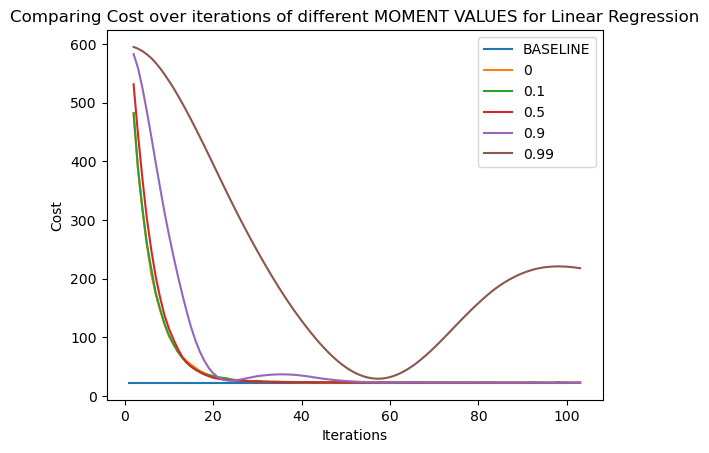

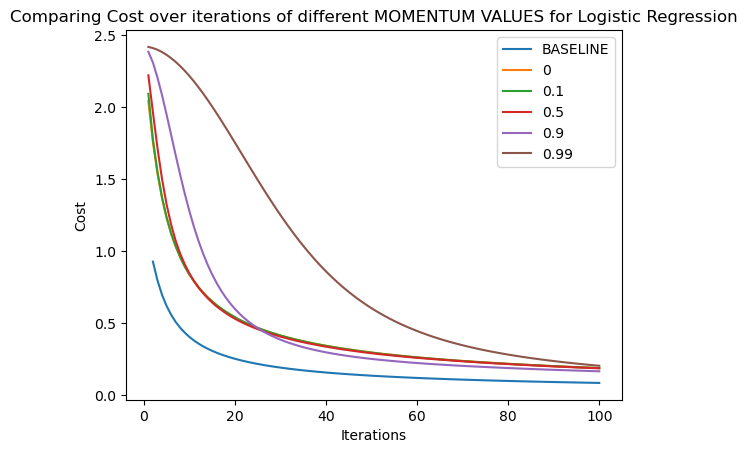

In [878]:
momentum_values = [0, 0.1, 0.5, 0.9, 0.99]
####Linear Regression
X_train_boston, X_test_boston, Y_train_boston, Y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, seed=1)
n = normalizer(X_train_boston)
X_train_boston = n.transform(X_train_boston)
X_test_boston = n.transform(X_test_boston)
#BASELINE
baseline = LinearReg(mini_batch=False, bias=True)
baseline.fit(X_train_boston, Y_train_boston)


plt.plot(np.arange(1,101), [MSE(baseline.predict(X_train_boston), Y_train_boston)] * 100, label="BASELINE")
#DIFFERENT BATCH SIZES
for i in momentum_values:
    reg = LinearReg(mini_batch=True, bias=True, max_iters=100, batchsize=64, learning_rate=0.1, verbose=True, beta_momentum=i)
    reg.fit(X_train_boston, Y_train_boston)
    iters, costers = reg.get_cost_with_iterations()
    plt.plot(iters, costers, label=f"{i}")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Comparing Cost over iterations of different MOMENT VALUES for Linear Regression")
plt.show()

###########################

###Logistic Regression
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(x_wine, y_wine, train_size=0.8, seed=1)
n = normalizer(X_train_wine)
X_train_wine = n.transform(X_train_wine)
X_test_wine = n.transform(X_test_wine)
#BASELINE
logreg = LogisticReg(mini_batch=False, bias=True, learning_rate=0.1, max_iters=100, verbose=True)
logreg.fit(X_train_wine, Y_train_wine)
iters, costers = logreg.get_cost_with_iterations()
plt.plot(iters, costers, label="BASELINE")
#DIFFERENT BATCH SIZES
for i in momentum_values:
    logreg = LogisticReg(mini_batch=True, bias=True, learning_rate=0.1, max_iters=100, batchsize=64, verbose=True, beta_momentum=i)
    logreg.fit(X_train_wine, Y_train_wine)
    iters, costers = logreg.get_cost_with_iterations()
    plt.plot(iters, costers, label=f"{i}")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Comparing Cost over iterations of different MOMENTUM VALUES for Logistic Regression")
plt.show()